<a href="https://colab.research.google.com/github/abksyed/EVA4/blob/master/S5/EVA4_S5_Assignment_iter05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Statements

In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

# Targets

**Overall Target to Acheive**
 

1.   99.4% (this must be consistently shown in your last few epochs, and not a one-time achievement)
2.   Less than or equal to 15 Epochs
3.   Less than 10000 Parameters

*Target Acheived in Last Iteration*

1.   Parameters Used: **8464**
1.   Test Accuracy: **99.41%**
2.   Training Accuracy: **99.18%**
2.   Epochs Used: **15**

*Target for this Iteration:*

1.   Stabalise the accuracy.
2.   Acheive 99.4% accuracy for 3-5 epochs consistently.
3.   Use ScheduledLR

#Raw Data Statistics

In [2]:
#Getting to know Data
data = datasets.MNIST('./data', train= True, transform= transforms.Compose([transforms.ToTensor(),]), download= True)

exp = data.data
exp = data.transform(exp.numpy())

print('Train Statistics')
print(' - Numpy Shape:', data.data.cpu().numpy().shape)
print(' - Tensor Shape:', data.data.size())
print(' - min:', torch.min(exp))
print(' - max:', torch.max(exp))
print(' - mean:', torch.mean(exp))
print(' - std:', torch.std(exp))
print(' - var:', torch.var(exp))

Train Statistics
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(0.)
 - max: tensor(1.)
 - mean: tensor(0.1305)
 - std: tensor(0.3081)
 - var: tensor(0.0949)


#Transforming Raw Data to Normalized Data

In [0]:
#Transforming Data (Normalizing to mean=1, std= 0)
train_transform = transforms.Compose([
                                      transforms.RandomRotation((-12.0,12.0), fill=(1,)),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.1311,), (0.3081,))
]
)

test_transform = transforms.Compose([
                                     transforms.ToTensor(),
                                     transforms.Normalize((0.1311,),(0.3081,))
])

#Creating Train/Test Split

In [0]:
#Getting Train and Test Data
train = datasets.MNIST('./data', train= True, transform= train_transform)
test = datasets.MNIST('./data', train= False, transform= test_transform)

#Dataloader Arguments & Test/Train Dataloaders

In [5]:
seed = 1

#CUDA Availability
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

#For Reproducibility
torch.manual_seed(seed)

if cuda:
    torch.cuda.manual_seed(seed)

dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory= True) if cuda else dict(shuffle= True, batch_size=64)

#Train Dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

#Test Dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


#**THE MODEL**

In [0]:
class Net(nn.Module):

  def __init__(self):

    super(Net, self).__init__()

    #Input Block - Input= 28
    self.block1 = nn.Sequential(
        nn.Conv2d(in_channels= 1, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(8),
       # nn.Dropout2d(0.1),
    ) #Output= 28 / ReceptiveField= 3

    #Convolution Block - Input= 28
    self.block2 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 8, kernel_size= 3, padding= 1, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(8),
        #nn.Dropout2d(0.1),
    ) #Output= 28 / ReceptiveField= 5

    #Max Pooling and 1x1 Convolution
    self.mp1 = nn.Sequential(
        nn.MaxPool2d(2)
    )#Output= 14 / ReceptiveField= 6

    #Convolution Block - Input= 14
    self.block3 = nn.Sequential(
        nn.Conv2d(in_channels= 8, out_channels= 12, kernel_size= 3, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        #nn.Dropout2d(0.1), 
        #Output= 12 / ReceptiveField= 10
        nn.Conv2d(in_channels= 12, out_channels= 12, kernel_size= 3, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        #nn.Dropout2d(0.1),
    ) #Output= 10 / ReceptiveField= 14  

    #Convolution Block - Input= 10
    self.block4 = nn.Sequential(
        nn.Conv2d(in_channels= 12, out_channels= 12, kernel_size= 3, padding= 0, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(12),
        #nn.Dropout2d(0.1),
        #Output= 8 / ReceptiveField= 18
        nn.Conv2d(in_channels= 12, out_channels= 16, kernel_size= 3, padding= 0, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        #nn.Dropout2d(0.1),
    ) #Output= 6 / ReceptiveField= 22
    
    #Convolution Block - Input= 6
    self.block5 = nn.Sequential(
        nn.Conv2d(in_channels= 16, out_channels= 16, kernel_size= 3, bias= False),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        #nn.Dropout2d(0.1),
    ) #Output= 4 / ReceptiveField= 26

    #GAP - Input 3
    self.gap = nn.AvgPool2d(4)
    #Output= 1 / ReceptiveField= 32
    
    self.conv = nn.Conv2d(in_channels= 16, out_channels= 10, kernel_size= 1, bias= False)

  def forward(self,x):

     x = self.block1(x)
     x = self.block2(x)
     x = self.mp1(x)
     x = self.block3(x)
     x = self.block4(x)
     x = self.block5(x)
     x = self.gap(x)
     x = self.conv(x)
     x = x.view(-1,10)

     return F.log_softmax(x, dim=-1)

#Inspecting Model Parameters

In [7]:
!pip install torchsummary
from torchsummary import summary

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 28, 28]              72
              ReLU-2            [-1, 8, 28, 28]               0
       BatchNorm2d-3            [-1, 8, 28, 28]              16
            Conv2d-4            [-1, 8, 28, 28]             576
              ReLU-5            [-1, 8, 28, 28]               0
       BatchNorm2d-6            [-1, 8, 28, 28]              16
         MaxPool2d-7            [-1, 8, 14, 14]               0
            Conv2d-8           [-1, 12, 12, 12]             864
              ReLU-9           [-1, 12, 12, 12]               0
      BatchNorm2d-10           [-1, 12, 12, 12]              24
           Conv2d-11           [-1, 12, 10, 10]           1,296
             ReLU-12           [-1, 12, 10, 10]               0
      BatchNorm2d-13           [-1, 12, 10, 10]              24
           Conv2d-14             [

#Training and Testing

In [0]:
from tqdm import tqdm

train_loss = []
test_loss = []

train_acc = []
train_endacc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)

    optimizer.zero_grad()

    y_pred = model(data)

    loss = F.nll_loss(y_pred, target)
    train_loss.append(loss)

    loss.backward()
    optimizer.step()

    pred = y_pred.argmax(dim=1, keepdim= True)
    correct+= pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100 * correct/processed)
  train_endacc.append(train_acc[-1])

In [0]:
def test(model, device, test_loader):
  model.eval()
  correct= 0
  tloss= 0

  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)

      output = model(data)

      tloss+= F.nll_loss(output, target, reduction= 'sum').item()
      pred= output.argmax(dim= 1, keepdim= True)
      correct+= pred.eq(target.view_as(pred)).sum().item()

  tloss /= len(test_loader.dataset)
  test_loss.append(tloss)
  print(100 * correct/len(test_loader.dataset))
  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        tloss, correct, len(test_loader.dataset),
        100 * correct/len(test_loader.dataset)))
  
  test_acc.append(100 * correct/len(test_loader.dataset))

#Running the Model

In [10]:
from torch.optim.lr_scheduler import StepLR

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr= 0.01, momentum= 0.9)
epochs = 15
scheduler = StepLR(optimizer, step_size= 7, gamma= 0.1)
for epoch in range(epochs):
  print('EPOCH: ', epoch+1)
  train(model, device, train_loader, optimizer, epoch)
  scheduler.step()
  test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

EPOCH:  1


Loss=0.04250643402338028 Batch_id=937 Accuracy=93.88: 100%|██████████| 938/938 [00:15<00:00, 61.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.62

Test set: Average loss: 0.0449, Accuracy: 9862/10000 (98.62%)

EPOCH:  2


Loss=0.06848883628845215 Batch_id=937 Accuracy=98.08: 100%|██████████| 938/938 [00:15<00:00, 59.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.96

Test set: Average loss: 0.0376, Accuracy: 9896/10000 (98.96%)

EPOCH:  3


Loss=0.2598465085029602 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:15<00:00, 60.93it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

98.91

Test set: Average loss: 0.0329, Accuracy: 9891/10000 (98.91%)

EPOCH:  4


Loss=0.03139156103134155 Batch_id=937 Accuracy=98.62: 100%|██████████| 938/938 [00:15<00:00, 61.04it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.07

Test set: Average loss: 0.0278, Accuracy: 9907/10000 (99.07%)

EPOCH:  5


Loss=0.011090263724327087 Batch_id=937 Accuracy=98.80: 100%|██████████| 938/938 [00:15<00:00, 60.20it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.26

Test set: Average loss: 0.0234, Accuracy: 9926/10000 (99.26%)

EPOCH:  6


Loss=0.046000316739082336 Batch_id=937 Accuracy=98.78: 100%|██████████| 938/938 [00:15<00:00, 60.22it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.17

Test set: Average loss: 0.0249, Accuracy: 9917/10000 (99.17%)

EPOCH:  7


Loss=0.0038566291332244873 Batch_id=937 Accuracy=98.94: 100%|██████████| 938/938 [00:15<00:00, 60.36it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.38

Test set: Average loss: 0.0199, Accuracy: 9938/10000 (99.38%)

EPOCH:  8


Loss=0.0144062340259552 Batch_id=937 Accuracy=99.17: 100%|██████████| 938/938 [00:15<00:00, 60.49it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.55

Test set: Average loss: 0.0153, Accuracy: 9955/10000 (99.55%)

EPOCH:  9


Loss=0.03775106370449066 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:15<00:00, 58.77it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.6

Test set: Average loss: 0.0151, Accuracy: 9960/10000 (99.60%)

EPOCH:  10


Loss=0.004320859909057617 Batch_id=937 Accuracy=99.29: 100%|██████████| 938/938 [00:15<00:00, 58.97it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.57

Test set: Average loss: 0.0154, Accuracy: 9957/10000 (99.57%)

EPOCH:  11


Loss=0.008017927408218384 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:16<00:00, 58.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.55

Test set: Average loss: 0.0154, Accuracy: 9955/10000 (99.55%)

EPOCH:  12


Loss=0.012802302837371826 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:15<00:00, 58.83it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.55

Test set: Average loss: 0.0147, Accuracy: 9955/10000 (99.55%)

EPOCH:  13


Loss=0.002640470862388611 Batch_id=937 Accuracy=99.30: 100%|██████████| 938/938 [00:15<00:00, 59.54it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.57

Test set: Average loss: 0.0148, Accuracy: 9957/10000 (99.57%)

EPOCH:  14


Loss=0.003788366913795471 Batch_id=937 Accuracy=99.33: 100%|██████████| 938/938 [00:15<00:00, 60.78it/s]
  0%|          | 0/938 [00:00<?, ?it/s]

99.6

Test set: Average loss: 0.0144, Accuracy: 9960/10000 (99.60%)

EPOCH:  15


Loss=0.008885711431503296 Batch_id=937 Accuracy=99.37: 100%|██████████| 938/938 [00:15<00:00, 59.85it/s]


99.58

Test set: Average loss: 0.0145, Accuracy: 9958/10000 (99.58%)



Text(0.5, 1.0, 'Test Accuracy')

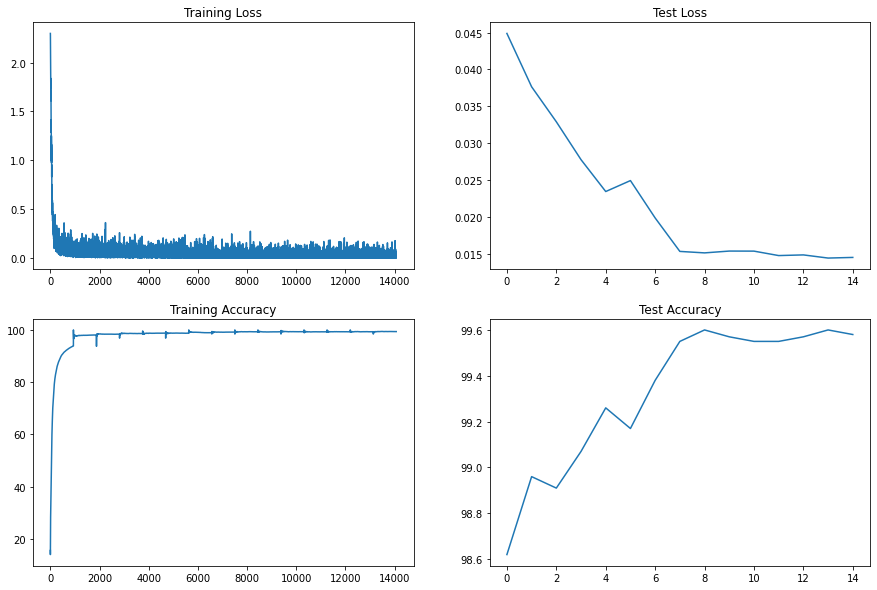

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_loss)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_loss)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

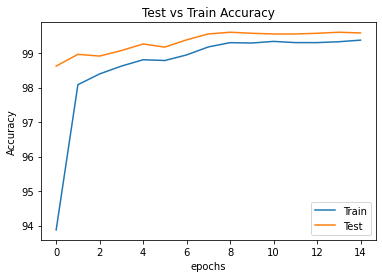

In [12]:
plt.axes(xlabel= 'epochs', ylabel= 'Accuracy')
plt.plot(train_endacc)
plt.plot(test_acc)
plt.title('Test vs Train Accuracy')
plt.legend(['Train', 'Test'])

In [13]:
print(f'Max Training Loss {min(train_loss)} with Max Training Accuracy {max(train_endacc)}\n')
print(f'Max Testing Loss {min(test_loss)} with Max Testing Accuracy {max(test_acc)}')

Max Training Loss 0.0002926141023635864 with Max Training Accuracy 99.37166666666667

Max Testing Loss 0.01440966169834137 with Max Testing Accuracy 99.6


#Results:



1.   Parameters Used: **8464**
1.   Test Accuracy: **99.60%**
2.   Training Accuracy: **99.37%**
2.   Epochs Used: **15**



#Analysis:



1.   Acheived 99.55% Test Accuracy at epoch:8
2.   StepLR has done wonders, keeping accuracy consistent.



*   Test accuracy 99.55 (epoch 8)
*   Test accuracy 99.60 (epoch 9)
*   Test accuracy 99.57 (epoch 10)
*   Test accuracy 99.55 (epoch 11)
*   Test accuracy 99.55 (epoch 12)
*   Test accuracy 99.57 (epoch 13)
*   Test accuracy 99.60 (epoch 14)
*   Test accuracy 99.58 (epoch 15)






